 <h1><center>Прогноз заказов такси</center></h1>

## Введение

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построем модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Алгоритм выполнения:
- загрузим данные
- выполним их ресемплирование по одному часу
- Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных
- Проверим модели на тестовой выборке и сделаем выводы

Загрузим библиотеки

In [1]:
import pandas as pd

from os import path
from pathlib import Path
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mlt
mlt.rcParams['figure.figsize'] = (10, 5)

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sqlalchemy import create_engine 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Обзор данных

Загрузим и посмотрим данные

In [2]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_name = 'taxi.csv'
#download dataset if not existed
if not path.exists(dataset_folder + '/' + dataset_name):
    #create dir if not existed
    Path(dataset_folder).mkdir(parents=True, exist_ok=True)

    #download dataset
    urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                               dataset_folder+'/'+ dataset_name)

df = pd.read_csv(dataset_folder +'/'+ dataset_name, index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим охваченный временной промежуток

In [4]:
print(df.index.min(), df.index.max())

2018-03-01 00:00:00 2018-08-31 23:50:00


# Обработка данных

Рассмотрим целевой признак

<AxesSubplot:>

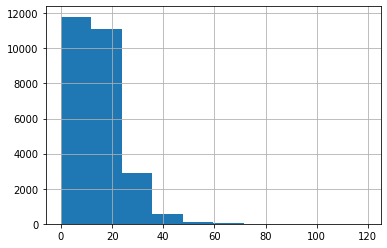

In [5]:
df["num_orders"].hist()

Сделаем ресемлинг по часу

In [6]:
df = df.resample('1H').sum()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


# Анализ данных

<AxesSubplot:xlabel='datetime'>

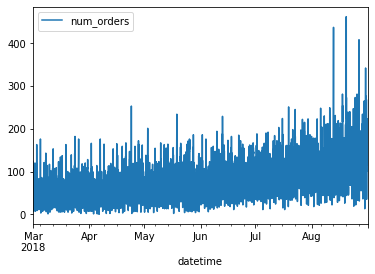

In [8]:
df.plot()

посмотрим на основные параметры временного ряда: тренд, сезонность, остатки

In [9]:
decomposed = seasonal_decompose(df)

<AxesSubplot:xlabel='datetime'>

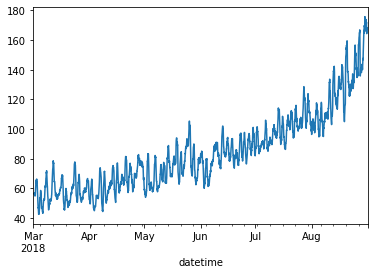

In [10]:
decomposed.trend.plot()

<AxesSubplot:xlabel='datetime'>

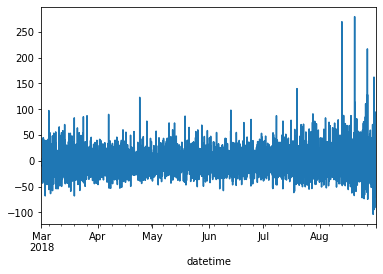

In [11]:
decomposed.resid.plot()

In [12]:
decomposed = seasonal_decompose(df["2018-03-01":"2018-03-03"])

<AxesSubplot:xlabel='datetime'>

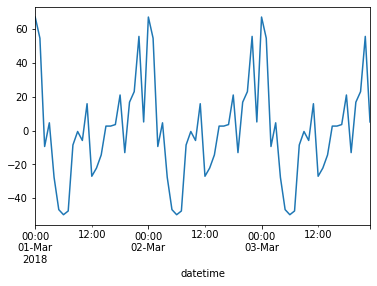

In [13]:
decomposed.seasonal.plot()

Единственное, что можно сказать, что пик заказов приходится на вечернее и ночное время, и что тренд на данной выборке растущий. С другой стороны у нас данные за неполный год.

Построим графики скользящего среднего и среднего отклонения по дням

In [14]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df["num_orders"].rolling(24).std()

<AxesSubplot:xlabel='datetime'>

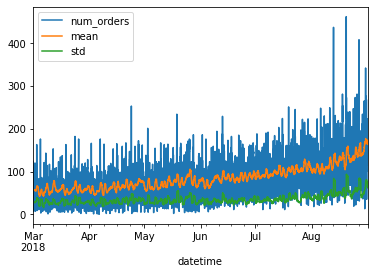

In [15]:
df.plot()

Можно сказать, что ряд не стационарный

Сделаем функцию для генерации признаков

In [16]:
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data = data.dropna()
    
    return data   

Возьмем кол-во признаком с отклонением равным 20

In [17]:
df = make_features(df, 20)

In [18]:
df.head()

,num_orders,mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 23:00:00,58,56.833333,29.409650,2018,3,1,3,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 00:00:00,90,55.416667,26.730404,2018,3,2,4,58.0,113.0,66.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 01:00:00,120,56.875000,29.250511,2018,3,2,4,90.0,58.0,113.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0
2018-03-02 02:00:00,75,57.041667,29.345734,2018,3,2,4,120.0,90.0,58.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0
2018-03-02 03:00:00,64,56.958333,29.322019,2018,3,2,4,75.0,120.0,90.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0


In [19]:
X = df.drop(columns={'num_orders'})
y = df["num_orders"]

# Построение моделей

Поделим нашу выборку на тест\трейн

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=1)
train = train.dropna()

Проверим временные индексы

In [21]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Выделим таргет

In [22]:
X_train = train.drop(columns={'num_orders'})
X_test = test.drop(columns={'num_orders'})
y_train = train['num_orders']
y_test = test['num_orders']

Разделим тренировочную на трейн\валидационную для кроссвалидации

In [23]:
tscv = TimeSeriesSplit(n_splits=5)
splits = tscv.split(X_train)

Проверим разбиение

In [24]:
for train_index, valid_index in splits:
    print("train_max_index:", train_index[-1], "test_min_index:", valid_index[0])
    print("train_lenght:", len(train_index),"test_lenght:", len(valid_index))

train_max_index: 662 test_min_index: 663
train_lenght: 663 test_lenght: 658
train_max_index: 1320 test_min_index: 1321
train_lenght: 1321 test_lenght: 658
train_max_index: 1978 test_min_index: 1979
train_lenght: 1979 test_lenght: 658
train_max_index: 2636 test_min_index: 2637
train_lenght: 2637 test_lenght: 658
train_max_index: 3294 test_min_index: 3295
train_lenght: 3295 test_lenght: 658


Сделаем сетки для перебора гиперпараметров в моделях. Возьмем линейную регрессию, random forest, catboost

In [25]:
param_rf = [
    {
     'n_estimators': [100, 200, 300, 400],
     'max_depth': [4, 6, 8],
     }
]

param_catboost = [
     {
      'n_estimators': [500, 1000],
      'max_depth': [4, 6, 8],
      'learning_rate': [0.05, 0.2, 0.01, 0.001]
      }
]

param_linear = [
     {}
]

In [26]:
names = ["rf", "catboost", "linreg"]
params = [param_rf, param_catboost, param_linear]
estimators = [RandomForestRegressor(random_state=1),
              CatBoostRegressor(verbose=0, random_state=1, od_type='Iter', od_wait=10,),
              LinearRegression()]

Сделаем перебор и посмотрим результаты

In [27]:
results = []

for estimator, param_grid, name in tqdm(zip(estimators, params, names)):
    gs = GridSearchCV(estimator,
                      param_grid,
                      scoring='neg_root_mean_squared_error',
                      refit='neg_root_mean_squared_error',
                      n_jobs=10,
                      cv=tscv)
                      
    gs.fit(X_train, y_train)

    result = {}
    result["model"] = name
    result["params"] = gs.best_estimator_.get_params()
    result["estimator"] = gs.best_estimator_
    result["rmse_valid"] = (-1)*gs.best_score_
    result["rmse_test"] = mean_squared_error(y_true=y_test,
                                             y_pred=gs.best_estimator_.predict(X_test),
                                             squared=False)
    results.append(result)

0it [00:00, ?it/s]

Результаты

In [28]:
df_results = pd.DataFrame(results)
df_results.sort_values(by="rmse_test", ascending=True, inplace=True)
df_results[["model", "rmse_valid", "rmse_test"]]

,model,rmse_valid,rmse_test
2,linreg,25.301171,39.492104
1,catboost,26.221570,47.686361
0,rf,28.946294,51.280850


Лучшая модель - линейная регрессия с параметром rmse = 39, что меньше заявленных требований

In [29]:
best_model = df_results.iloc[0]["estimator"]
pred = best_model.predict(X)
y = y.to_frame()
y["orders_pred"] = pred

<AxesSubplot:xlabel='datetime'>

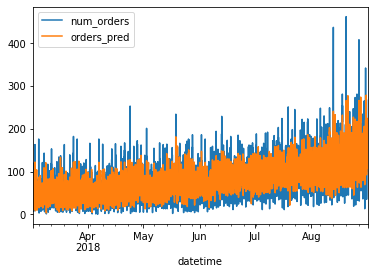

In [30]:
y[["num_orders", "orders_pred"]].plot()

## Вывод

Нам были даны исторические данные компании, предоставляющей сервис такси. Нужно было посмотрить модель для прогнозирования спроса на следующий час. Мы сделали обработку данных, перебором гиперпараметров нашли, что лучшая модель для данной задачи - линейная регрессия. Параметр rmse=39, что меньше требуемого заказчиком в описании задачи 